In [34]:
import drawing
import imp
imp.reload(drawing)

<module 'drawing' from '/u/home/lyrebird_code/handwriting_synthesis/drawing.py'>

In [2]:
import numpy as np

import os

import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]


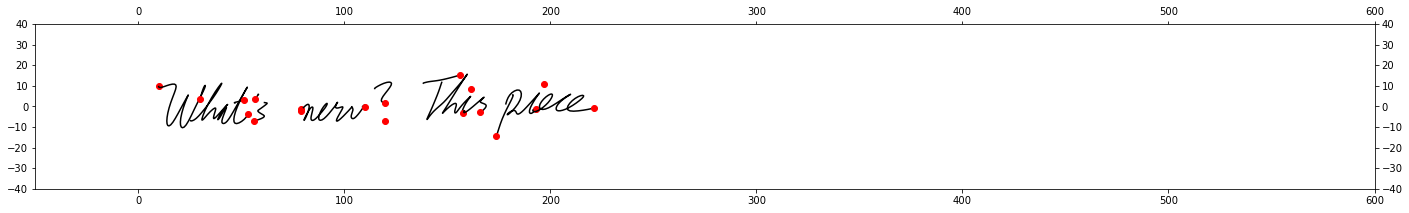

In [4]:
drawing.draw(data[0][0])

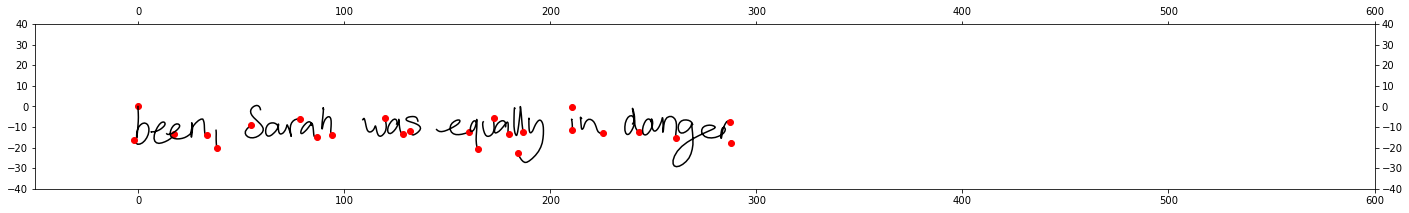

tensor([11196])
833
been, Sarah was equally in danger.


In [5]:
index = torch.randint(strokes.shape[0], (1,))
text = drawing.decode_ascii(strings[index])
drawing.draw(strokes[index], align_strokes=False, denoise_strokes=False)
print(index)
print(stroke_lens[index])
print(text)

In [6]:
import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [7]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx]
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

In [8]:
next(iter(train_dataloader))[0].shape

torch.Size([1, 1200, 3])

In [9]:
len(train_dataloader)
len(test_dataloader)

10000

1911

In [10]:
!pwd

/u/home/lyrebird_code/handwriting_synthesis


In [11]:
from tqdm import tqdm

cuda:0
n_iter: 0 of 100000, loss: 0.005060491617769003
n_iter: 500 of 100000, loss: 2.415259599685669
n_iter: 1000 of 100000, loss: 2.262423038482666
n_iter: 1500 of 100000, loss: 2.371595621109009
n_iter: 2000 of 100000, loss: 2.354013681411743
n_iter: 2500 of 100000, loss: 2.2823498249053955
n_iter: 3000 of 100000, loss: 2.38505482673645
n_iter: 3500 of 100000, loss: 2.282252788543701
n_iter: 4000 of 100000, loss: 2.2105233669281006
n_iter: 4500 of 100000, loss: 2.300356864929199
n_iter: 5000 of 100000, loss: 2.3190813064575195
n_iter: 5500 of 100000, loss: 2.31321120262146
n_iter: 6000 of 100000, loss: 2.2912728786468506
n_iter: 6500 of 100000, loss: 2.245999336242676
n_iter: 7000 of 100000, loss: 2.1940739154815674
n_iter: 7500 of 100000, loss: 2.3092567920684814
n_iter: 8000 of 100000, loss: 2.29649019241333
n_iter: 8500 of 100000, loss: 2.299196720123291
n_iter: 9000 of 100000, loss: 2.2537505626678467
n_iter: 9500 of 100000, loss: 2.3710782527923584
n_iter: 10000 of 100000, loss

n_iter: 83500 of 100000, loss: 2.3633220195770264
n_iter: 84000 of 100000, loss: 2.266770362854004
n_iter: 84500 of 100000, loss: 2.28556227684021
n_iter: 85000 of 100000, loss: 2.260805606842041
n_iter: 85500 of 100000, loss: 2.2235798835754395
n_iter: 86000 of 100000, loss: 2.2087819576263428
n_iter: 86500 of 100000, loss: 2.287397861480713
n_iter: 87000 of 100000, loss: 2.2696292400360107
n_iter: 87500 of 100000, loss: 2.276959180831909
n_iter: 88000 of 100000, loss: 2.309053421020508
n_iter: 88500 of 100000, loss: 2.2149884700775146
n_iter: 89000 of 100000, loss: 2.311227798461914
n_iter: 89500 of 100000, loss: 2.2989704608917236
n_iter: 90000 of 100000, loss: 2.28666353225708
n_iter: 90500 of 100000, loss: 2.2613134384155273
n_iter: 91000 of 100000, loss: 2.2524585723876953
n_iter: 91500 of 100000, loss: 2.1630280017852783
n_iter: 92000 of 100000, loss: 2.278177499771118
n_iter: 92500 of 100000, loss: 2.2401041984558105
n_iter: 93000 of 100000, loss: 2.2709896564483643
n_iter: 935

<Figure size 432x288 with 0 Axes>

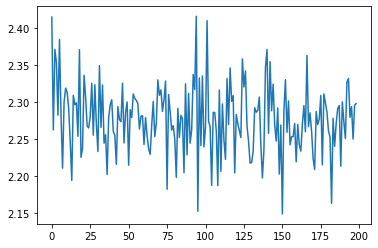

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm_out = nn.LSTM(hidden_size+hidden_size, input_size, batch_first=True)
        
    def forward(self, x, h0, c0, he, ce):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm_out(torch.cat((out1, out2), -1), (he, ce))
        return out3
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, 1, self.hidden_size), torch.zeros(batch_size, 1, self.hidden_size)

def train(model, input_stroke, stroke_len, optimizer, loss_fnc, h0, c0, he, ce):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0, he, ce)
    #     print(out.shape)
    #     print(input_stroke[:,:stroke_len-1,:].shape)
    assert(out.shape == input_stroke[:,:stroke_len-1,:].shape)
    loss = loss_fnc(out, input_stroke[:,1:stroke_len,:])
    loss.backward()
    optimizer.step()
    return loss.item()
    
input_size = 3
hidden_size = 500
batch_size = 1
m = HandWritingPredictionWithLSTM(input_size, hidden_size).to(device)
optim = torch.optim.Adam(m.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

# s, l = next(iter(train_dataloader))
# loss = train(
#     model=m,
#     input_stroke=s.squeeze(dim=2).to(device),
#     stroke_len=l.item(),
#     optimizer=optim,
#     loss_fnc=loss_function,
#     h0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     c0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     he=torch.zeros(batch_size, 1, input_size, device=device),
#     ce=torch.zeros(batch_size, 1, input_size, device=device))

# torch.save({
#             'epoch': 2,
#             'model_state_dict': m.state_dict(),
#             'optimizer_state_dict': optim.state_dict(),
#             'loss': loss,
#             }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")

print_every = 500
n_epochs = 10
n_iters = 0
losses = []
total_loss = 0

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            loss_fnc=loss_function,
            h0=h0, c0=c0, he=he, ce=ce)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

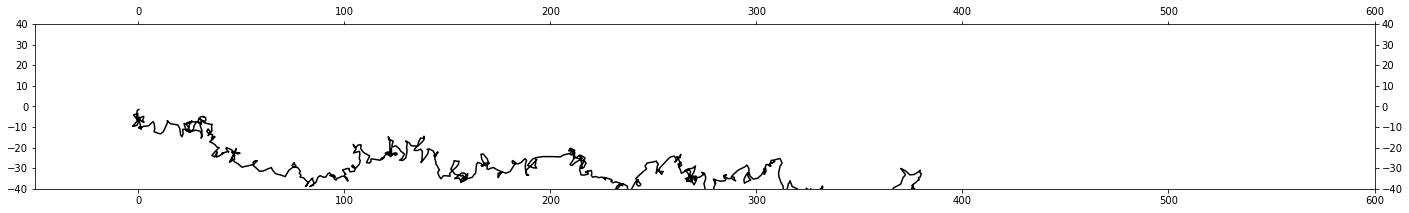

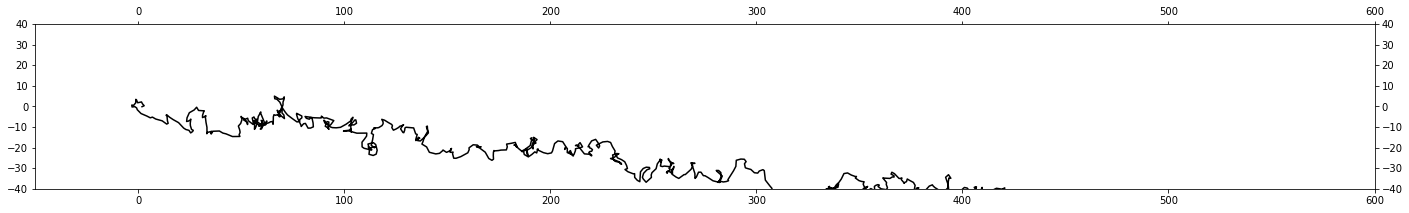

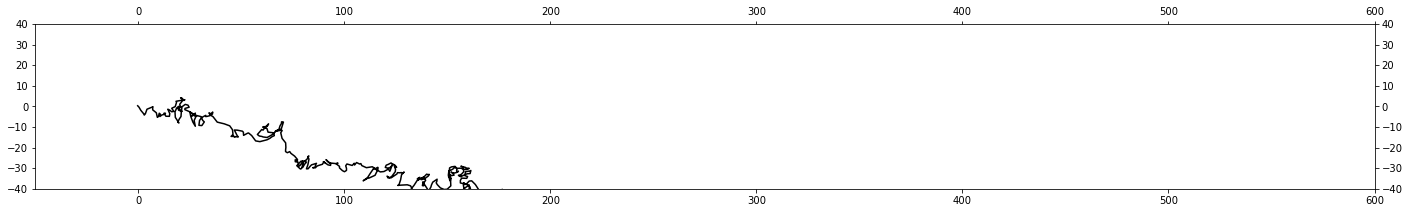

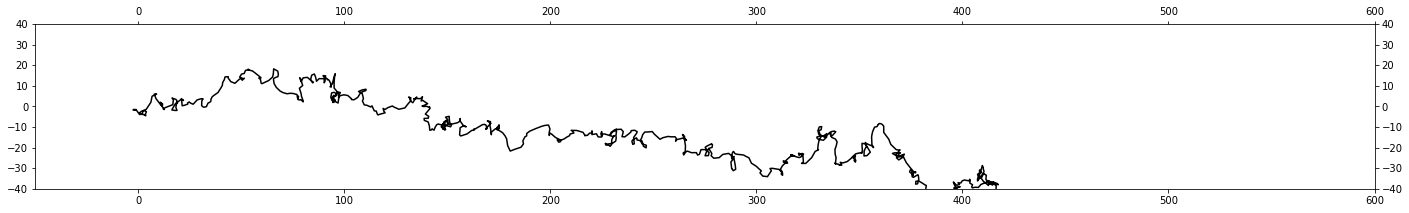

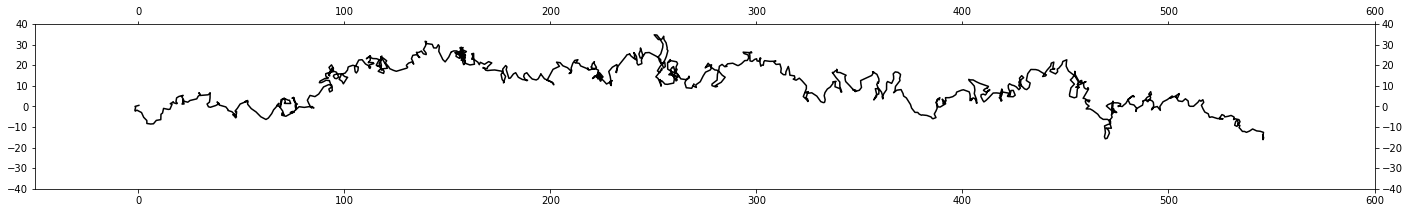

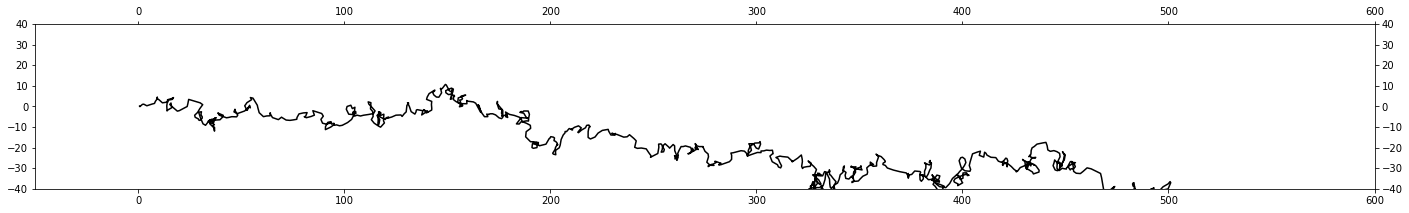

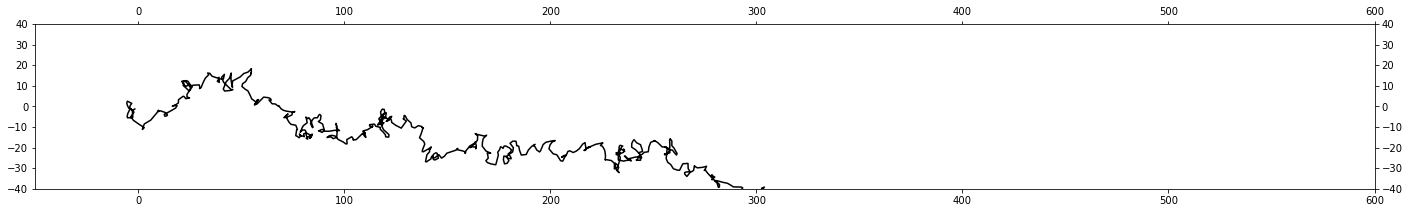

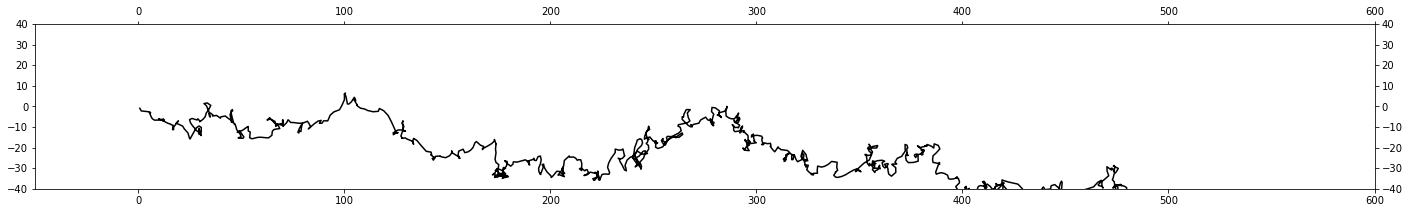

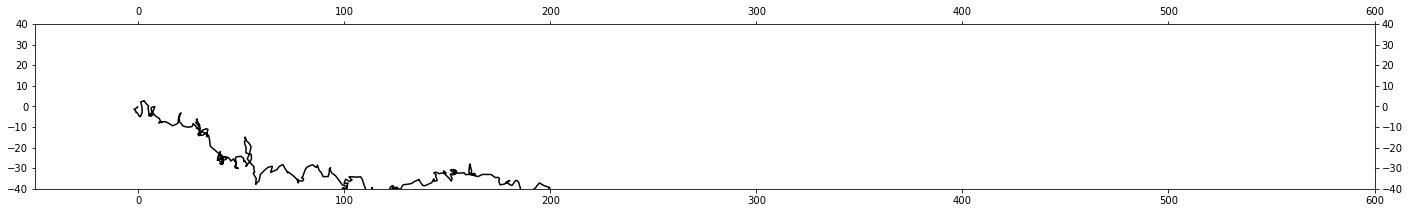

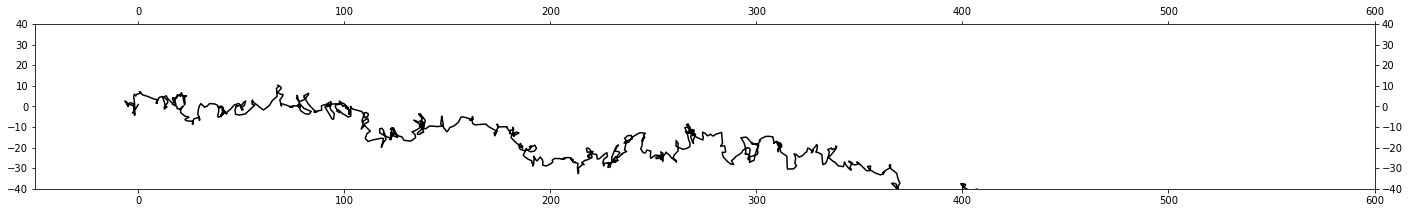

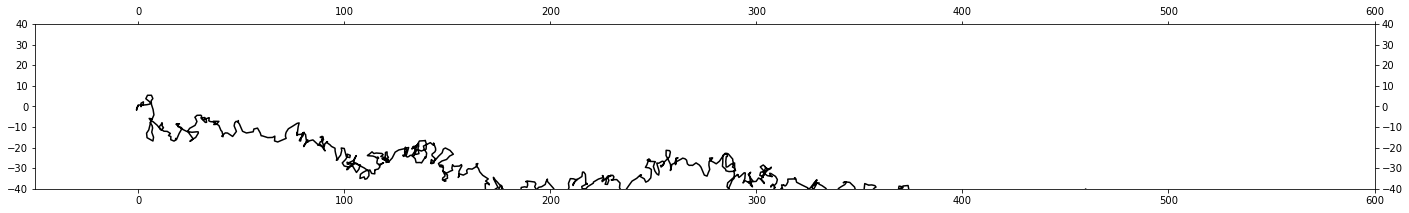

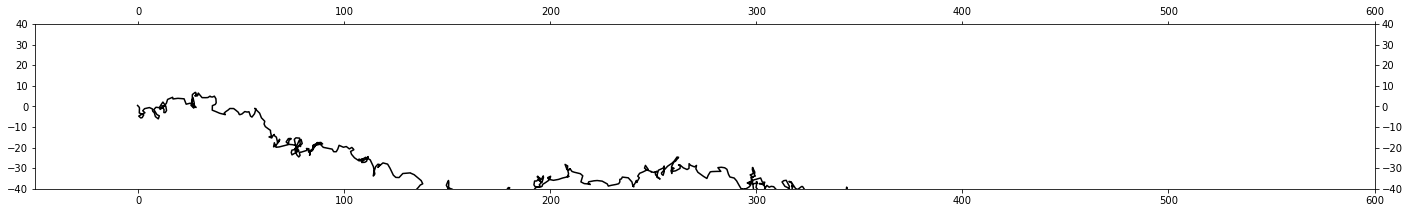

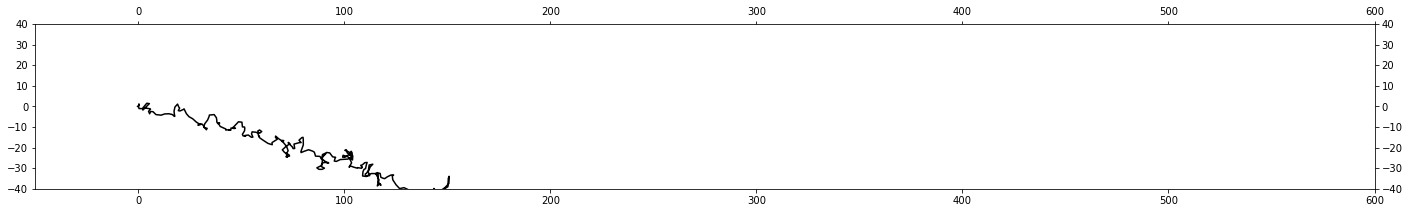

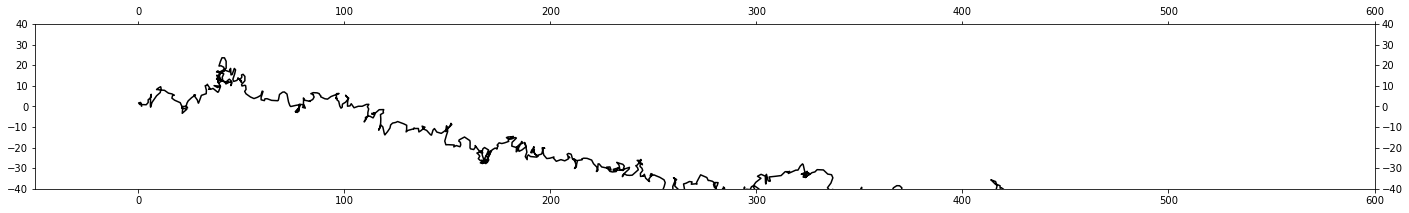

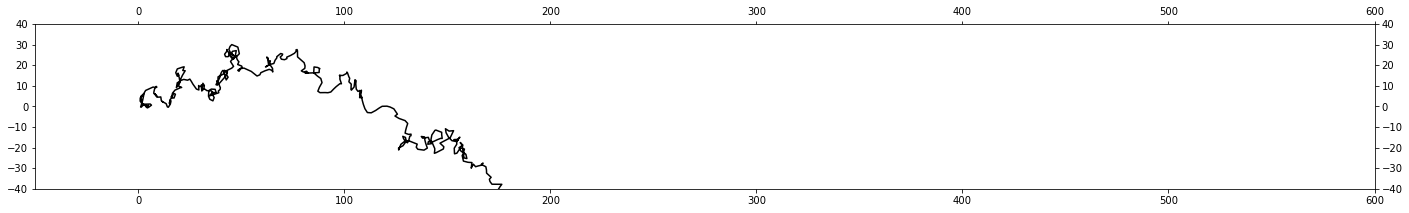

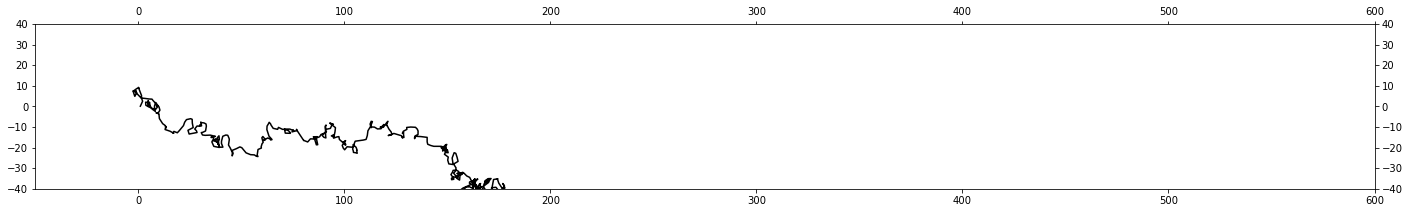

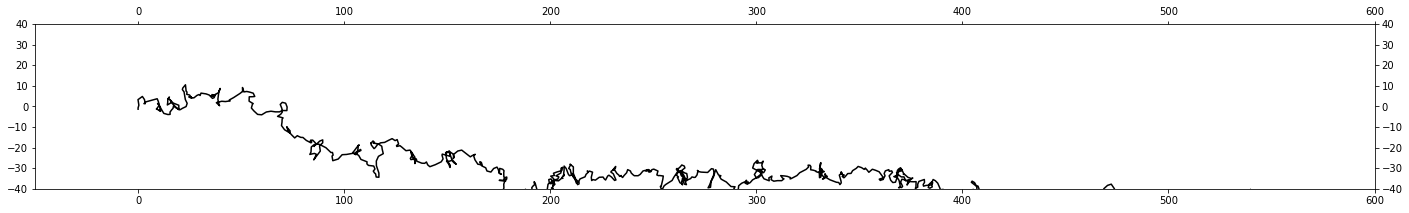

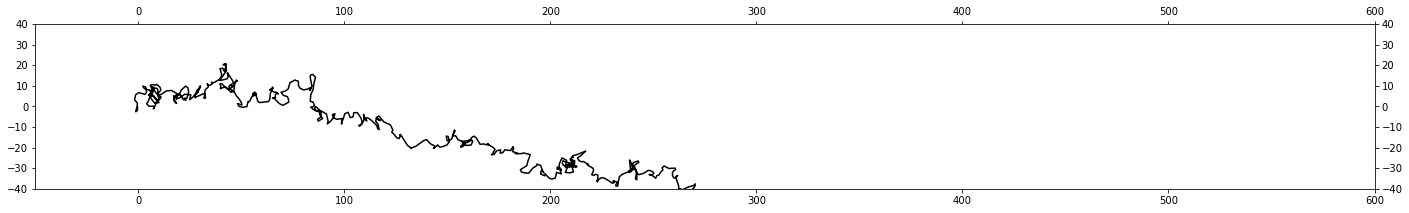

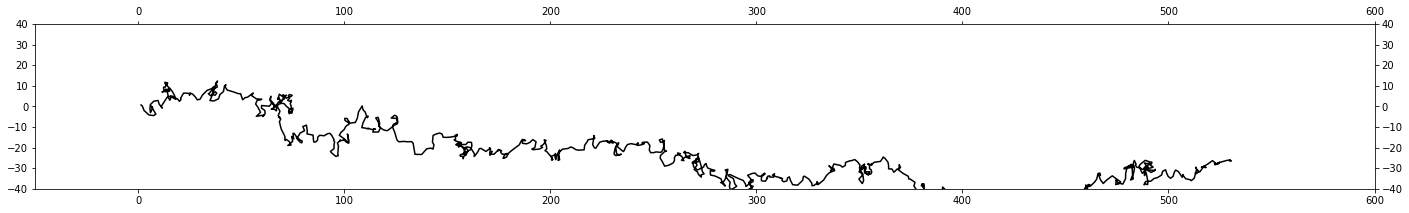

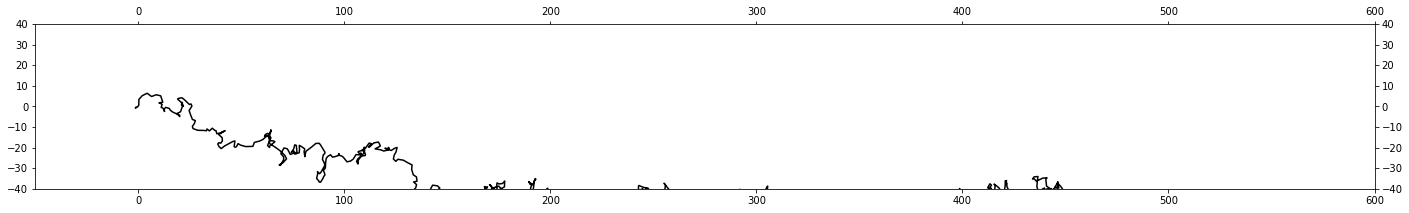

In [37]:
def sample_drawing():
    timestamps = 1200
    with torch.no_grad():
        h0=torch.zeros(batch_size, 1, hidden_size, device=device)
        c0=torch.zeros(batch_size, 1, hidden_size, device=device)
        h1=torch.zeros(batch_size, 1, hidden_size, device=device)
        c1=torch.zeros(batch_size, 1, hidden_size, device=device)
        he=torch.zeros(batch_size, 1, input_size, device=device)
        ce=torch.zeros(batch_size, 1, input_size, device=device)
        predictions = torch.zeros(timestamps, 3, device=device)
        predictions[0, 2] = 1
        for i in range(timestamps-1):
            inp = predictions[i].unsqueeze(0).unsqueeze(1)
            #print(inp.unsqueeze(0).unsqueeze(1))
            #print(h0.shape, c0.shape)
            out1, (h0, c0) = m.lstm1(inp, (h0, c0))
            #print(output.shape, h0.shape, c0.shape)
            out2, (h1, c1) = m.lstm2(torch.cat((inp, out1), -1), (h1, c1))
            out3, (he, ce) = m.lstm_out(torch.cat((out1, out2), -1), (he, ce))
            #print(output.shape, he.shape, ce.shape)
            
            pen_off = np.random.binomial(1,1/(1 + torch.exp(he.reshape(-1)[2]).item()))

            sample_point = np.random.multivariate_normal(
                he.reshape(-1)[:2].cpu().numpy(), np.eye(2))
            predictions[i+1, 0:2] = torch.tensor(sample_point)
            predictions[i+1, 2] = 0#pen_off
            
        drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False, plot_end_points=False)
    

for i in range(20):
    sample_drawing()

    
# start = torch.tensor([0, 0, 1], dtype=torch.float32, device=device)
# with torch.no_grad():
#     a = m(start.unsqueeze(0).unsqueeze(1), h0, c0, he, ce)
# print(a.shape)
# #a[:, :, 2] = a[:, :, 2] > 0.0000001
# #a
# a.reshape(-1)
# a

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00],
        [-2.9708e-02, -1.0593e-01, -4.3004e-07],
        [ 1.4487e-02, -1.5787e-01,  7.7240e-04],
        ...,
        [ 9.9593e-02, -7.6576e-03,  3.8567e-04],
        [ 7.9598e-02, -1.5965e-03,  1.9179e-02],
        [ 6.4441e-02, -4.4192e-03,  4.2313e-02]], device='cuda:0')

/tmp/ipykernel_394/4257299992.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions_th = torch.tensor(predictions)


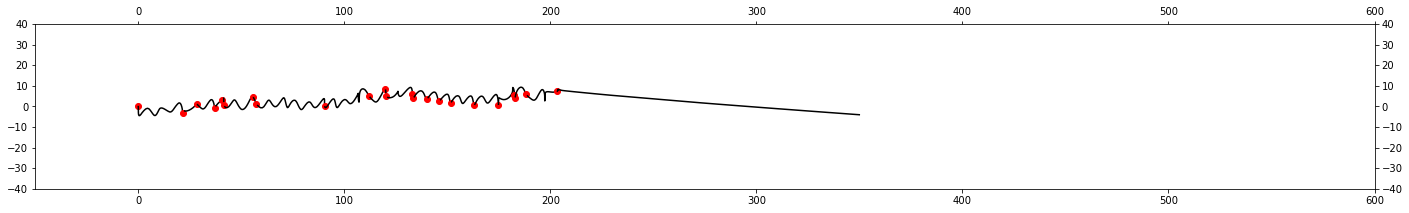

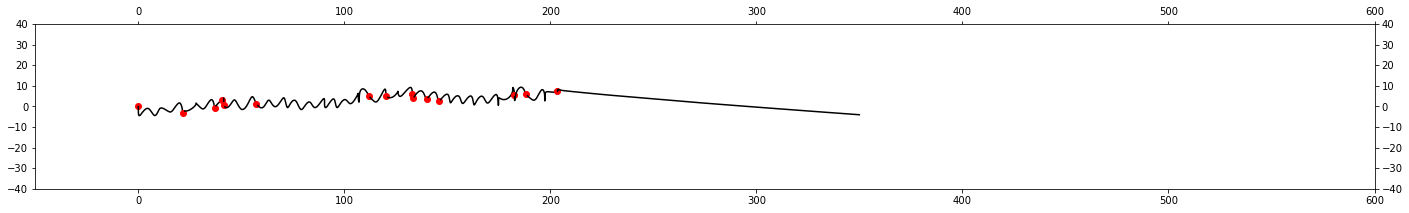

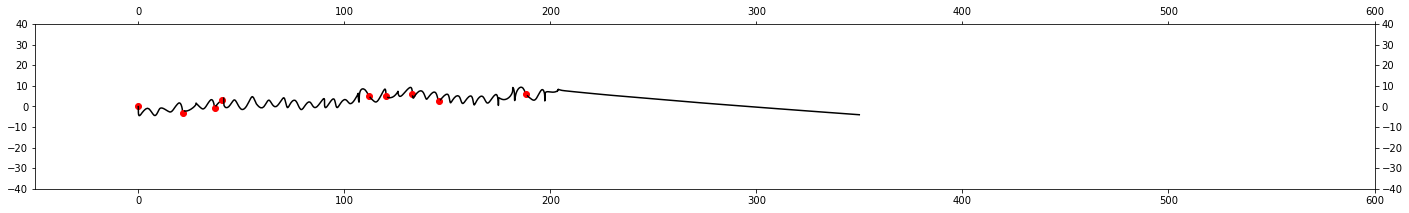

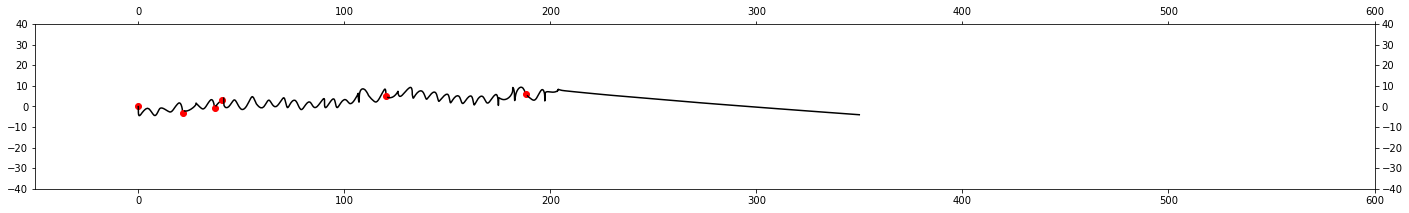

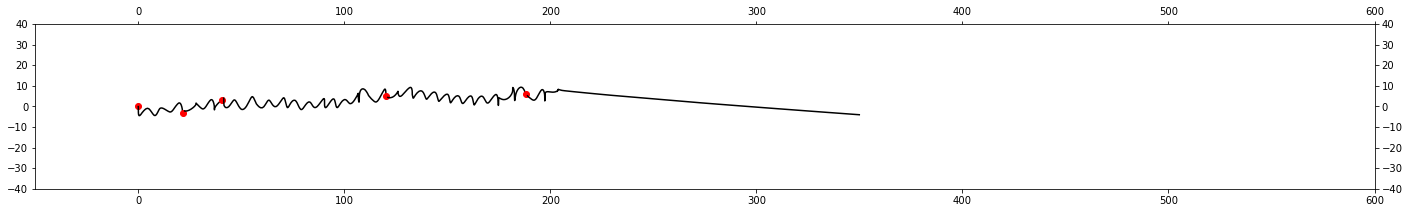

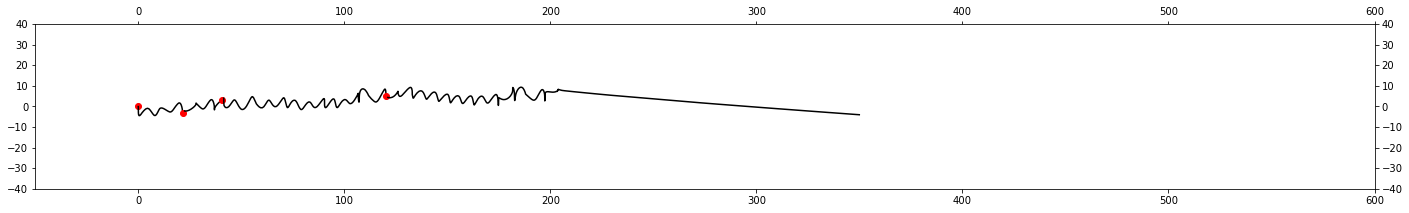

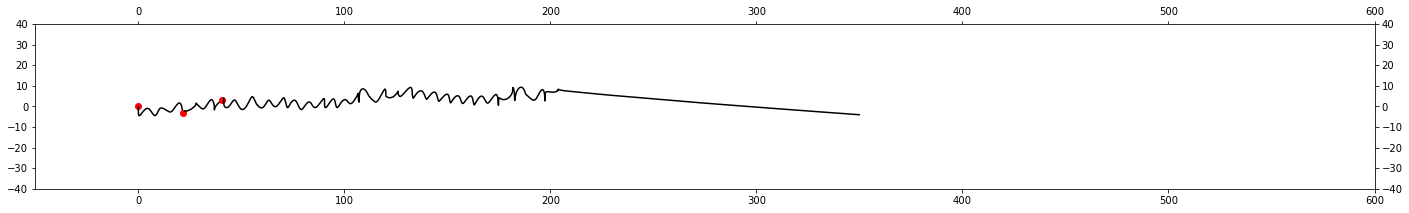

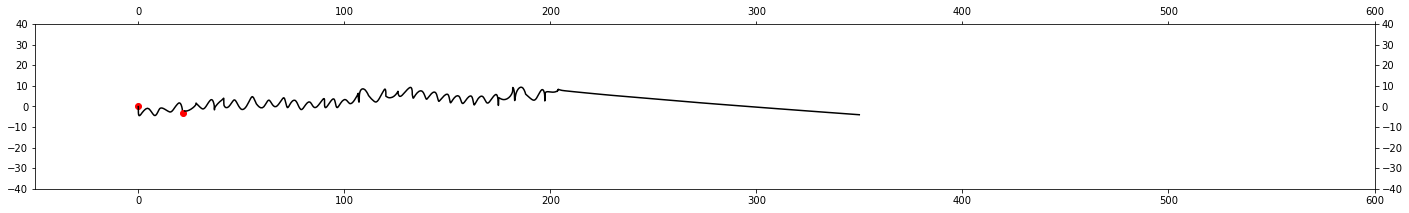

In [23]:
predictions

for threshold in np.arange(0.1, 0.9, 0.1):
    predictions_th = torch.tensor(predictions)
    predictions_th[:, 2] = predictions_th[:, 2] > threshold
    drawing.draw(predictions_th.cpu(), align_strokes=False, denoise_strokes=False)


In [ ]:
def sample(model, predictions):
    with torch.no_grad():
        start = predictions[0]
        for i in range(len(predictions)-1):
            print(model(start.unsqueeze_(0), h0, ).shape()) 
    

In [13]:
class LSTMExp(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMExp, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
    def forward(self, x, h0, c0):
        return self.lstm(x, (h0, c0))
    
input_size = 3
seq_length = 12
hidden_size = 100
batch_size = 10
x = torch.rand(batch_size, seq_length, input_size)
h0 = torch.rand(1, batch_size, hidden_size)
c0 = torch.rand(1, batch_size, hidden_size)
m = LSTMExp(input_size, hidden_size)
out, (hn, cn) = m(x, h0, c0)
print(out.shape)
print(hn.shape)
print(cn.shape)

torch.save({
            'epoch': 2,
            'model_state_dict': m.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses[-1],
            }, "model_checkpoints/")

torch.Size([10, 12, 100])
torch.Size([1, 10, 100])
torch.Size([1, 10, 100])


In [46]:
MAX_SEQ_LENGTH = 1200

class HandWritingPrediction(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HandWritingPrediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmCell1 = nn.LSTMCell(input_size, hidden_size)
        self.lstmCell2 = nn.LSTMCell(hidden_size + input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, input_size)
        self.num_activations = 4 # 2 for each lstm layers
    
    def forward(self, x, activations, idx):
        activations_new[0], activations_new[1] = self.lstmCell1(
            x, (activations_old[0], activations_old[1]))
        activations_new[2], activations_new[3] = self.lstmCell2(
            torch.cat((x, activations_old[2]), 1), (aactivations_old[2], activations_old[3]))
        out = self.linear(activations_old[2])
        return out, activations_old, activations_new
    
    def init_hidden(self, bs, device):
        return torch.zeros(self.num_activations, bs, self.hidden_size).to(device)


In [40]:
def train(model, input_stroke, stroke_len, optimizer, loss_fnc, activations1, activations2):
    optimizer.zero_grad()
    bs = 1
    loss = 0
    for i, pt in enumerate(input_stroke[:stroke_len-1]):
        out, activations = model(pt, activations1, activations2)
        loss += loss_fnc(out, input_stroke[i+1])
    loss = loss/(stroke_len-1)
    loss.backward()
    optimizer.step()
    return loss

In [41]:
def eval(model, input_stroke, stroke_len, loss_fnc, activations):
    with torch.no_grad():
        bs = 1
        loss = 0
        for i, pt in enumerate(input_stroke[:stroke_len-1]):
            out, activations = model(pt, activations, i)
            loss += loss_fnc(out, input_stroke[i+1])
        loss = loss/len(inputs)
        return loss

In [42]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [43]:
batch_size = 1
n_hidden = 1000
n_input = 3

model = HandWritingPrediction(n_input, n_hidden).to(device)
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

    



In [45]:
print_every = 100
n_epochs = 2
n_iters = 0
losses = []
total_loss = 0
activations = model.init_hidden(batch_size, device)

torch.autograd.set_detect_anomaly(True)

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(model, strokes[0].to(device), stroke_lens.item(), optim, loss_function, activations)
        activations.zero_()
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}")
        n_iters += 1

[W python_anomaly_mode.cpp:104] Warning: Error detected in ThnnFusedLstmCellBackward. Traceback of forward call that caused the error:
  File "/home/miniconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/miniconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/miniconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/miniconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/miniconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 667, in start
    self.io_loop.start()
  File "/home/miniconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/miniconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  Fil

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 1000]], which is output 0 of AsStridedBackward, is at version 2049; expected version 2047 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

<Figure size 432x288 with 0 Axes>

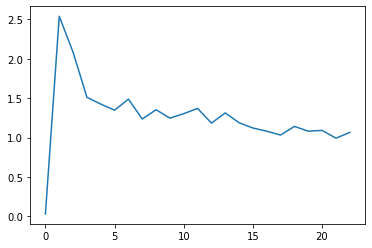

In [38]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)

In [90]:
from torch.nn.utils.rnn import pack_padded_sequence
s, l = next(iter(train_dataloader))
s.shape
l.shape
#packed = pack_padded_sequence(s, l, batch_first=True, enforce_sorted=False)

#model(packed, h, c)

torch.Size([1, 1200, 3])

torch.Size([1])

In [96]:
eval(model, s[0], l.item(), loss_function)

torch.Size([702, 1, 3])
torch.Size([702, 1, 3])
torch.Size([1, 1000])


tensor(3.1328)